In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from scipy.optimize import curve_fit
import scipy.stats

In [2]:
@njit()
def compute_signature_plot(vol_size,array):
    sigma = np.zeros(vol_size)
    for i in range(1,vol_size+1):
        new_arr = array[::i]
        square_sum = (new_arr[1:] - new_arr[:-1])**2
        sigma[i-1] = square_sum.sum()
        
    return np.sqrt(sigma)

@njit()
def compute_price_impact(price,sign,max_lag,step=1):
    impact = []
    std_impact = []
    for i in range(1,max_lag,step):
        impact.append((-sign[:-i]*(price[i:]-price[:-i])).mean())
        std_impact.append((-sign[:-i]*(price[i:]-price[:-i])).std() / np.sqrt(len(price[i:])))
    
    return impact, std_impact

def linear(x,m,q):
    return m * x + q

def find_param(xx,yy):
    popt, pcov = curve_fit(linear, xx, yy)
    m = popt[0]
    q = popt[1]
    err_m = np.sqrt(pcov[0][0])
    err_q = np.sqrt(pcov[1][1])

    
    return m, q, err_m, err_q
    
    plt.style.use('dark_background')

# Loading and cleaning data

Dopo aver caricato i dati Lobster, per ogni giorno ho visto quello che era lo stato dell'order book con una frequenza di campionamento al secondo.

Per ogni giorno ho eliminato la prima ora e l'ultima mezz'ora di trade.

Infine ho unito i dati di ogni giorno così ottenuti in un unico dataframe.

In [3]:
#create a list of all the files in the folder
DIR ="C:\\Users\\spina\\Documents\\SOLDI\\data\\tesla_2015\\order\\"
tesla_files =os.listdir(DIR)
header_list = ["ask price","ask vol","bid price","bid vol"]

#create a list of all the files in the folder
DIR_1 ="C:\\Users\\spina\\Documents\\SOLDI\\data\\tesla_2015\\message\\"
tesla_files_1 =os.listdir(DIR_1)

header_list_1 = ["time","event type","order ID","size","price","direction"]
lst_message = []
lst_order = []
# crate a new dataframe that shows the state of the LOB each second
for message, order in zip(tesla_files_1, tesla_files):
    
    #load message dataframe
    df_m = pd.read_csv(DIR_1 + message, names = header_list_1)
    # find status LOB every second
    secs = []
    start = 34201
    for i,element in enumerate(df_m["time"]):           
        if start < element:
            while start < element:
                secs.append(i-1)
                start += 1

    # ignore the first hour and last 30 minutes of trading
    secs = secs[3600:-1800]
    df_m = df_m.iloc[secs]
    
    # load order dataframe
    df_o = pd.read_csv(DIR + order, names=header_list,usecols=[0,1,2,3])
    df_o = df_o.iloc[secs] 
    #scale price to dollar cent
    df_o["ask price"] = df_o["ask price"]/100
    df_o["bid price"] = df_o["bid price"]/100
    # add spread and mid price
    df_o["spread"] = df_o["ask price"] - df_o["bid price"]
    df_o["mid price"] = (df_o["ask price"] + df_o["bid price"]) / 2
    
    lst_message.append(df_m)
    lst_order.append(df_o)

In [4]:
# unite the data for each day in two unique dataframe
df_message = pd.concat(lst_message)
df_message.reset_index(inplace=True, drop = True)
df_order = pd.concat(lst_order)
df_order.reset_index(inplace=True, drop = True)
df_order.head()

,ask price,ask vol,bid price,bid vol,spread,mid price
0,21661.0,101,21639.0,100,22.0,21650.0
1,21658.0,100,21639.0,100,19.0,21648.5
2,21658.0,200,21634.0,200,24.0,21646.0
3,21654.0,100,21634.0,200,20.0,21644.0
4,21654.0,100,21634.0,200,20.0,21644.0


In [5]:
values = df_message["event type"].value_counts()
print("Limit orders = ", values.iloc[0])
print("Market orders = ", values.iloc[2])
print("Cancel orders = ", values.iloc[1])

Limit orders =  238861
Market orders =  1336
Cancel orders =  118984


In [6]:
df_order.agg(
    {
        "ask price": ["min", "max", "mean","std"],
        "ask vol": ["min", "max", "mean","std"],
        "bid price": ["min", "max", "mean","std"],
        "bid vol": ["min", "max", "mean","std"],
        "spread": ["min", "max", "mean","std"],
        "mid price": ["min", "max", "mean","std"],
    }).round(2)


,ask price,ask vol,bid price,bid vol,spread,mid price
min,18712.00,1.00,18701.00,1.00,1.00,18706.50
max,21839.00,20200.00,21823.00,14334.00,61.00,21829.00
mean,20281.28,151.21,20266.58,160.94,14.70,20273.93
std,726.00,265.61,725.14,273.53,5.41,725.56


# Mid price

Dopo aver caricato e pulito i dati ho plottato l'andamento del mid price in funzione del tempo, con frequenza di campionamento al minuto

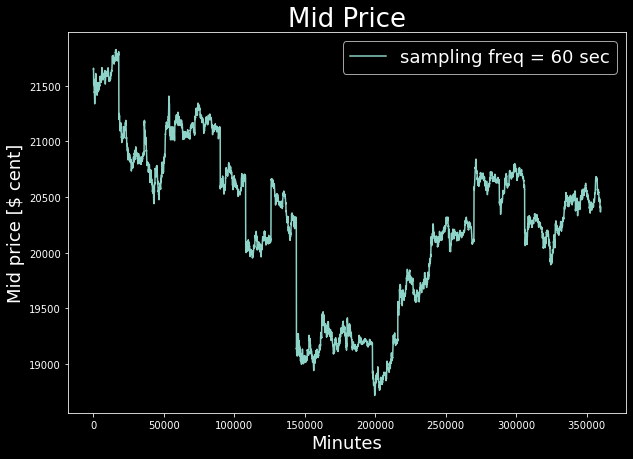

In [33]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
plt.title("Mid Price", fontsize = 26)
plt.xlabel("Minutes", fontsize = 18)
plt.ylabel("Mid price [$ cent]", fontsize = 18)
plt.plot(df_order["mid price"].iloc[::60],label = "sampling freq = 60 sec")
plt.legend(fontsize = 18)
plt.show()

# Spread distribution

Dopodiché ho plottato la distribuzione dello spread con frequenza di campionamento al secondo in scala semilogaritmica.

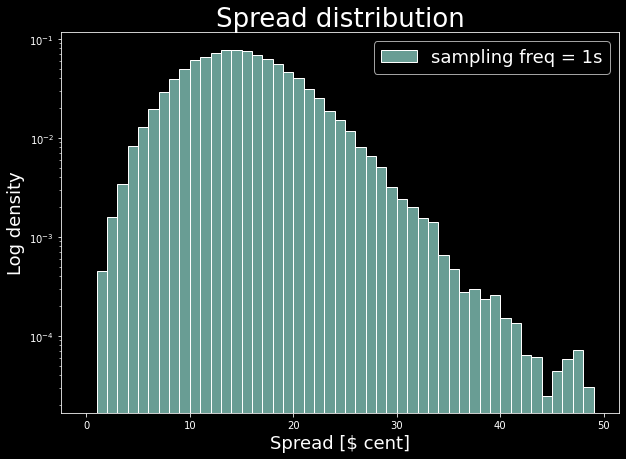

In [34]:
fig,ax = plt.subplots(1,1,figsize = (10,7))

spr = df_order["spread"]

sns.histplot(data=df_order,x="spread",bins=np.arange(50),stat="density", label="sampling freq = 1s")
plt.style.use('dark_background')
plt.title("Spread distribution", fontsize=26)
plt.xlabel("Spread [$ cent]",fontsize=18)
plt.ylabel("Log density",fontsize=18)
plt.yscale("log")
plt.legend(fontsize=18)
plt.show()

# Log return distribution

Successivamente ho plottato in scala semilogaritmica la distribuzione del logaritmo dei ritorni:

$r = log(p_{t+1}- p_{t})$

con frequenza di campionamento al minuto.

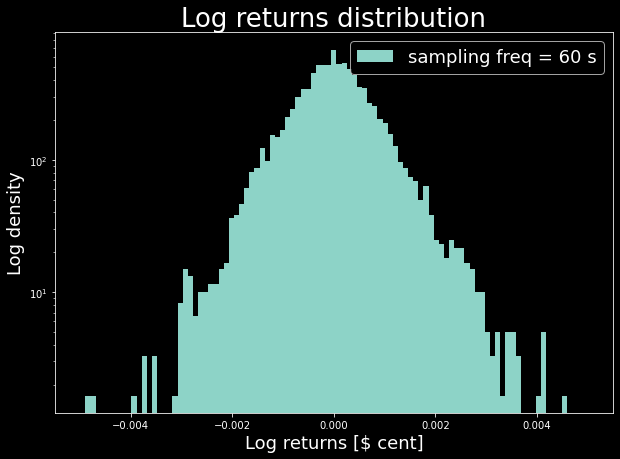

In [9]:
fig,ax = plt.subplots(1,1,figsize = (10,7))

diff_log = np.log(df_order["mid price"].iloc[60::60].to_numpy()) - \
            np.log(df_order["mid price"].iloc[:-60:60].to_numpy())
xx = np.linspace(-0.005,0.005,100)
plt.hist(diff_log,bins=xx, density=True, label="sampling freq = 60 s")
plt.title("Log returns distribution",fontsize=26)
plt.ylabel("Log density",fontsize=18)
plt.xlabel("Log returns [$ cent]",fontsize=18)
plt.yscale("log")
#plt.plot(xx, scipy.stats.norm.pdf(xx, loc = diff_log.mean(), scale = diff_log.std()),label="gaussian")
plt.legend(fontsize=18)
plt.show()


# Signature plot

Poi ho graficato la volatilità:

$\sigma(\tau) = \frac{1}{\tau}<(p_{t+\tau} - p_t)^2>$

in funzione di $\tau$.

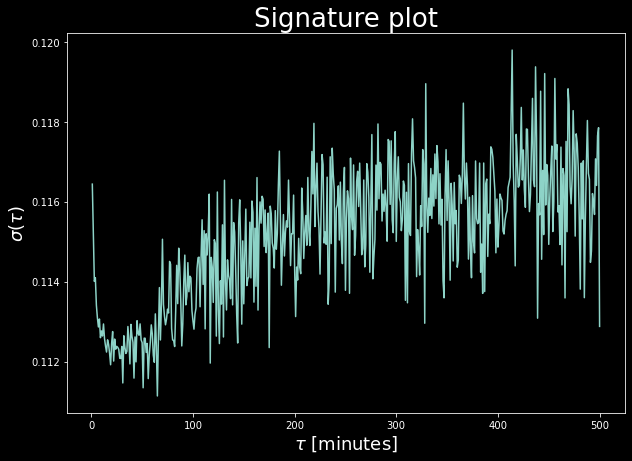

In [77]:
fig,ax = plt.subplots(1,1,figsize = (10,7))

m_price = np.log(df_order["mid price"].to_numpy())
volatility = compute_signature_plot(500,m_price)

x = np.arange(1,501)
plt.plot(x,volatility)


plt.xlabel(r"$\tau$ [minutes]",fontsize=18)
plt.ylabel(r"$\sigma(\tau)$",fontsize=18)
plt.title("Signature plot",fontsize=26)
plt.show()

In [28]:
a = np.log(df_order["mid price"])
corr = np.zeros(100)
for i in range(1,101):
    corr[i-1] = (a.diff(i)).autocorr(i)

In [32]:
a.diff()

0              NaN
1        -0.000069
2        -0.000115
3        -0.000092
4         0.000000
            ...   
359975   -0.000073
359976    0.000000
359977    0.000000
359978    0.000024
359979   -0.000049
Name: mid price, Length: 359980, dtype: float64

# Price impact

In [64]:
#create a list of all the files in the folder
DIR ="C:\\Users\\spina\\Documents\\SOLDI\\data\\tesla_2015\\order\\"
tesla_files =os.listdir(DIR)
header_list = ["ask price","ask vol","bid price","bid vol"]

#create a list of all the files in the folder
DIR_1 ="C:\\Users\\spina\\Documents\\SOLDI\\data\\tesla_2015\\message\\"
tesla_files_1 =os.listdir(DIR_1)

header_list_1 = ["time","event type","order ID","size","price","direction"]
lst_message = []
lst_order = []
# crate a new dataframe that shows the state of the LOB each second
for message, order in zip(tesla_files_1, tesla_files):
    #load message dataframe
    df_m = pd.read_csv(DIR_1 + message, names = header_list_1)
    # delete first hour and last 30 minutes of trading
    df_m = df_m[df_m["time"]> 37800]
    df_m = df_m[df_m["time"]< 55800]
    #consider the dataframe of all the market order
    df_market = df_m[df_m["event type"] == 4]
    df_market["time"] = (df_market["time"]*1000) // 1
    value = df_market["time"].iat[0]
    unique_orders = []
    #iterate over all the row in the dataframe and check if there is a difference higher
    # than 1/100 sec between two market order, if this is not the case the two orders
    # are considered the same
    for i,element in enumerate(df_market["time"]):
        if element == value:
            j = i + 1
            while value == element and j < len(df_market):
                value = df_market["time"].iat[j]
                j += 1
            unique_orders.append(i)
    
    df_market = df_market.iloc[unique_orders]
    market_orders = df_market.index.to_numpy() - 1
    # load order dataframe
    df_o = pd.read_csv(DIR + order, names=header_list,usecols=[0,1,2,3])
    #scale price to dollar cent
    df_o["ask price"] = df_o["ask price"]/100
    df_o["bid price"] = df_o["bid price"]/100
    # add spread and mid price
    df_o["spread"] = df_o["ask price"] - df_o["bid price"]
    df_o["mid price"] = (df_o["ask price"] + df_o["bid price"]) / 2
    #
    df_o = df_o.loc[market_orders]
    
    lst_message.append(df_market)
    lst_order.append(df_o)

<ipython-input-64-d450092a1517>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_market["time"] = (df_market["time"]*1000) // 1


In [65]:
lag_impact = []
err_impact = []
for df_m, df_o in zip(lst_message, lst_order):
    sign = df_m["direction"].to_numpy()
    mid_p = df_o["mid price"].to_numpy()
    p_impact,err = compute_price_impact(mid_p,sign,5)
    lag_impact.append(p_impact[0])
    err_impact.append(err[0])
    


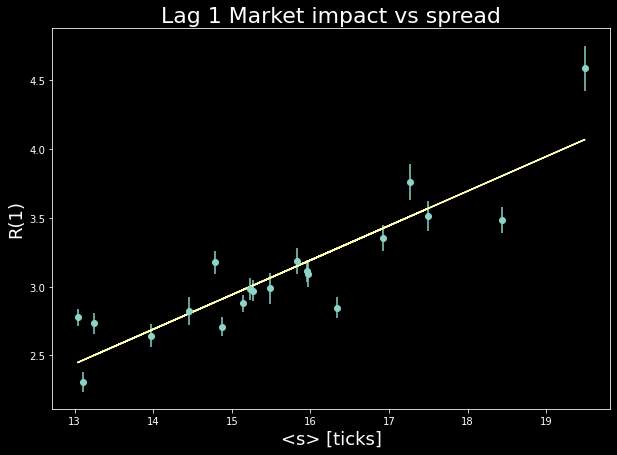

In [66]:
fig,ax = plt.subplots(1,1,figsize = (10,7))

m, q, err_m, err_q = find_param(param_df2["spread"], lag_impact)
plt.errorbar(x = param_df2["spread"], y = lag_impact, yerr = err_impact, ls="", marker = "o")
plt.plot(param_df2["spread"], linear(param_df2["spread"], m, q))
plt.title("Lag 1 Market impact vs spread", fontsize = 22)
plt.xlabel("<s> [ticks]", fontsize = 18)
plt.ylabel("R(1)", fontsize = 18)
plt.show()


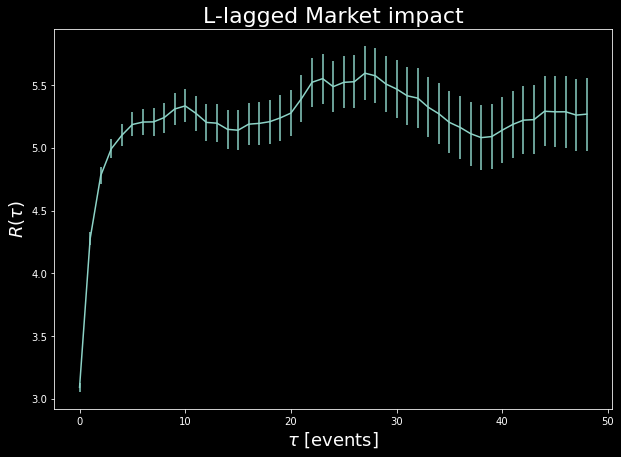

In [69]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
plt.title("L-lagged Market impact",fontsize = 22) 
all_markets = pd.concat(lst_message)
all_orders  = pd.concat(lst_order)
sign_orders = all_markets["direction"].to_numpy()
mid_p = all_orders["mid price"].to_numpy()
p_impact,err = compute_price_impact(mid_p,sign_orders,50)
plt.xlabel(r"$\tau$ [events]", fontsize = 18)
plt.ylabel(r"$R(\tau)$", fontsize = 18)
x = np.arange(49)
plt.errorbar(x, p_impact, yerr = err)
plt.show()

# autocorrelation market order flow

In [75]:
corr = np.zeros(100)
for i in range(100):
    corr[i] = all_markets["direction"].autocorr(i)

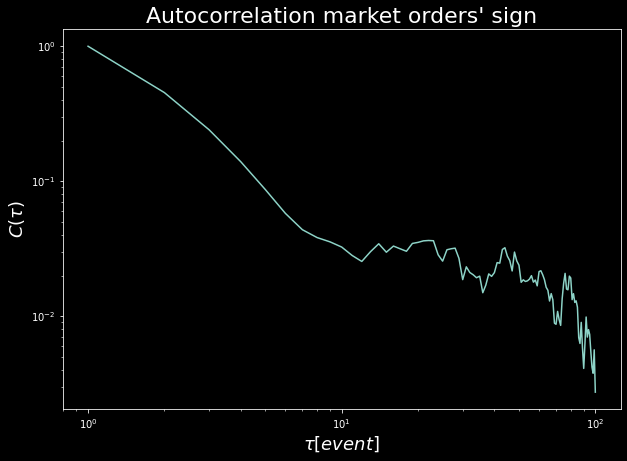

In [76]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
xx = np.arange(1,101)
plt.plot(xx,corr)
plt.loglog()
plt.ylabel(r"$C(\tau)$", fontsize = 18)
plt.xlabel(r"$\tau [event]$", fontsize = 18)
plt.title("Autocorrelation market orders' sign", fontsize=22)
plt.show()

# Are arrival times a poisson process?

In [ ]:
import statsmodels.api as sm
import scipy.stats

In [ ]:
times = all_markets["time"].to_numpy()
arrival_times = (times[1:]- times[:-1])[:350]

print(f"mean arrival time {arrival_times.mean():.2f} sec")

In [ ]:

sm.qqplot(arrival_times, scipy.stats.expon, scale=arrival_times.mean(), line = "45")
plt.show()

# Parameters estimation 

In [38]:
col_name = ["date", "mid_price", "spread", "lambda", "v", "u", "V_0", "volume","volatility", "gap to spread"]
param_df2 = pd.read_csv("../data/santa_fe_parameter_estimation_2.txt",names=col_name)
param_df2

,date,mid_price,spread,lambda,v,u,V_0,volume,volatility,gap to spread
0,2.0,21581.506504,15.956322,0.030436,0.121010,0.047497,104.0,146.556735,104.293278,0.255479
1,5.0,20954.758076,16.343016,0.031356,0.110191,0.044293,101.0,148.712249,140.234087,0.247638
2,6.0,20801.767517,18.434805,0.026991,0.132050,0.037549,103.0,137.747831,226.705569,0.247447
3,7.0,21110.859354,19.492539,0.027078,0.132017,0.031620,106.0,141.824752,61.995050,0.247147
4,8.0,21182.646278,15.480661,0.030184,0.129562,0.036751,101.0,142.316304,75.592971,0.224967
5,9.0,20645.612870,15.232554,0.031053,0.105472,0.044524,101.0,168.301881,70.333321,0.225652
6,12.0,20069.024038,14.877731,0.031280,0.090671,0.061024,99.0,176.179327,55.631613,0.222334
7,13.0,20362.488660,16.927618,0.028637,0.109795,0.045203,101.0,153.579983,143.855868,0.214639
8,14.0,19107.678672,15.144992,0.030746,0.112438,0.057251,101.0,148.930635,74.617307,0.247612
9,15.0,19264.522087,15.274812,0.032356,0.116189,0.039351,97.0,143.425042,89.250980,0.205092


In [52]:
param_df2["spread"].round(2)

0     15.96
1     16.34
2     18.43
3     19.49
4     15.48
5     15.23
6     14.88
7     16.93
8     15.14
9     15.27
10    13.11
11    13.04
12    14.79
13    13.24
14    13.97
15    14.46
16    17.27
17    17.49
18    15.83
19    15.97
Name: spread, dtype: float64